In [ ]:
# Comment the following lines if you're not in colab:
from google.colab import drive
drive.mount('/content/drive')
# If you're in colab, cd to your own working directory here:
%cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-4

# <u>GPU Training and Model Tuning</u>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch as tc
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchsummary import summary

In [ ]:
seed = 42
np.random.seed(seed)
tc.manual_seed(seed)

## <u>CUDA</u>

PyTorch relies on CUDA for Nvidia GPUs to perform fast tensor operations. There is also ROCm support for AMD GPUs, but, I have no experience in it.

In order to train your model on an Nvidia GPU, you need to:
- Install the required CUDA drivers (check here https://pytorch.org/ which ones are supported by the last stable PyTorch version)
- Install Pytorch with CUDA support (same link)
- Mount tensors to GPU using `tensor.to("cuda")`, or `tensor.cuda()`, or even, better, by defining the device once the tensor is created, e.g., `x = tc.tensor(5, device=device)`

Careful: In order to do any operation between two tensors, they need to be on the same device. E.g., you should not add a tensor that is in CPU with a tensor that is in GPU. For instance, this will raise an error: <br>
`tc.tensor([5, 5], device="cpu") + tc.tensor([10, 1], device="cuda")`

To safeguard against these issues, it is common to fetch and use the device we have (GPU if available, else CPU) like so:

In [ ]:
device = tc.device("cuda" if tc.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## <u>Validation and Hyperparameters </u>

Once we have assembled our architecture, there are still many aspects that we can tune in order to make it work better. For example, we can change the batch size, learning rate, number of training epochs, or other application-specific hyperparameters. Ideally, we would like to choose the parameters that have the best generalization capability (e.g., we'd like to find a suitable number of epochs so that the model gets properly trained without overfitting). However, we cannot use our test dataset for that. I know it is tempting to do so (and a lot of people out there are doing it), but, if you choose the hyperparameters that yield the best performance on the test data, you're essentially using them to "train" your model.

**REMEMBER**: You should use your test dataset only to assess your **final final** model. Never touch the test dataset before the model is ready-to-deploy.

So, how do we tune our model to reach a good generalization capability? A typical solution is to further split the training data in a training and validation dataset. The validation set is used only to tune our hyperparameters:

In [ ]:
# hyperparameters
batch_size = 16
lr = 8e-4
n_epochs = 100
adam_betas = (0.9, 0.9)
train_val_split = [.8, .2]

In [ ]:
datapath = 'data'

# load dataset
data_train = MNIST(
    root = datapath,
    train = True,
    transform = ToTensor(),
    download = True
)
data_test = MNIST(
    root = datapath,
    train = False,
    transform = ToTensor(),
    download = True
)

# Keep some data for validation:
data_train, data_val = random_split(
    dataset=data_train,
    lengths=train_val_split,
    generator=tc.Generator()
)

digit.shape = torch.Size([1, 28, 28])


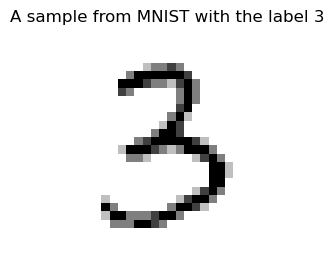

In [ ]:
digit, label = data_train[0]
digit = digit.to(device)
print(f"digit.shape = {digit.shape}")

plt.figure(figsize=(3,3))
plt.imshow(digit[0].cpu(), cmap='binary')
plt.axis('off')
plt.title(f"A sample from MNIST with the label {label}")
plt.show()
plt.close()

Now we'll have 3 data loaders (one for each set of data):

In [ ]:
train_loader = DataLoader(
    dataset=data_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=2
)

val_loader = DataLoader(
    dataset=data_val,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

test_loader = DataLoader(
    dataset=data_test,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

print(f"Dataset sizes:\n Train = {len(data_train)}\n Val   = {len(data_val)}\n Test  = {len(data_test)}")

Dataset sizes:
 Train = 48000
 Val   = 12000
 Test  = 10000


This time, we will create a bigger Multilayer Perceptron (MLP) to classify MNIST digits. So, each image must be flattened before it gets inputted in the network:

In [ ]:
class SimpleMLP(nn.Module):
    """
    - input_shape: shape of a single input data point
    """
    def __init__(self, input_shape, n_classes):
        super(SimpleMLP, self).__init__()

        self.input_shape = np.asarray(input_shape)
        self.n_classes = n_classes

        self.seq_model = nn.Sequential(
            nn.Linear(in_features=self.input_shape.prod(), out_features=64),
            nn.PReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.PReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=self.n_classes)
        )

    def forward(self, x):
        x = x.view(-1, self.input_shape.prod())  # make the input of shape (batch_size, height*weight)
        logits = self.seq_model(x)
        return logits

Create an instance of the model, do a forward pass, and print its architecture:

In [ ]:
model = SimpleMLP(input_shape=digit.shape, n_classes=10).to(device)
out = model(digit)
print(f"Input shape = {digit.shape}, Output shape = {out.shape}")
_ = summary(model=model, input_data=digit.shape, device=device)

Input shape = torch.Size([1, 28, 28]), Output shape = torch.Size([1, 10])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 64]                  50,240
|    └─PReLU: 2-2                        [-1, 64]                  1
|    └─Linear: 2-3                       [-1, 32]                  2,080
|    └─PReLU: 2-4                        [-1, 32]                  1
|    └─Linear: 2-5                       [-1, 16]                  528
|    └─PReLU: 2-6                        [-1, 16]                  1
|    └─Linear: 2-7                       [-1, 10]                  170
Total params: 53,021
Trainable params: 53,021
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21


As in our second tutorial, we'll create a function to measure accuracy:

In [ ]:
def model_accuracy(data_loader):
    n_total = 0
    n_correct = 0

    for x_batch_, y_batch_ in data_loader:
        x_batch_, y_batch_ = x_batch_.to(device), y_batch_.to(device)
        logits_batch_ = model(x_batch_)  # model's output scores
        n_total += len(y_batch_)
        n_correct += sum(logits_batch_.argmax(axis=-1) == y_batch_).item()
    return n_correct / n_total

print(f"Accuracies before training:\n Train = {model_accuracy(train_loader):.4f}\n Val   = {model_accuracy(val_loader):.4f}\n Test  = {model_accuracy(test_loader):.4f}")

Accuracies before training:
 Train = 0.1122
 Val   = 0.1130
 Test  = 0.1135


Define loss and optimizer:

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = tc.optim.Adam(model.parameters(), lr=lr, betas=adam_betas)

### <u>Overfitting and early stopping</u>

Overfitting is one of the main problems that you will encounter in your deep learning journey. The most common sign that a model overfits, is when it achieves good performance on the training data, but it does not generalize on the validation and test data.

When this happens, there are many counter measures that you can take, for example:
- Decrease the number of parameters of your model
- Use regularization techniques (Dropout, L1-L2 regularization, batch normalization)
- Reduce the number of epochs

In particular, a common approach for the last point is to use *early stopping*. Just as the name says, early stopping consists in interrupting the training process if the model stops improving based on some criterion. Typically, if the validation loss (or accuracy) reaches a plateau, i.e., stops improving.

Parameters of the early stopping are typically:
- `patience`, i.e., how many epochs to wait before deciding to stop training
- `min_delta`, a minimum difference between the last recorded best value and the new best value to consider it an improvement (we won't use it in this example)

In [ ]:
# Early stopping parameters:
patience = 5  # epochs
best_acc_val = 0.0
early_stop_counter = 0

Here is the main training loop for our MLP with early stopping:

In [ ]:
accuracies_train = []
accuracies_val = []

for epoch in range(n_epochs):

    for i, (x_batch, y_batch) in enumerate(train_loader):

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits_batch = model(x_batch)
        loss_batch = loss_fn(input=logits_batch, target=y_batch)
        loss_batch.backward()
        optimizer.step()

    # evaluate the model at the end of each epoch:
    with tc.no_grad():

        acc_train = model_accuracy(train_loader)
        acc_val = model_accuracy(val_loader)
        print(f"Epoch {epoch+1:03d} | train_acc = {acc_train:.4f} | val_acc = {acc_val:.4f}")
        accuracies_train.append(acc_train)
        accuracies_val.append(acc_val)

        # save the weights iff the validation accuracy increased:
        if acc_val > best_acc_val:
            best_acc_val = acc_val
            early_stop_counter = 0
            tc.save(model.state_dict(), f"saved_models/MLP_GPU_epoch{epoch+1:03d}.pt")
        else:
            early_stop_counter += 1
            if early_stop_counter == patience:
                print(f"Validation accuracy has not improved in {patience} epochs: training stopped.")
                break

Epoch 001 | train_acc = 0.9302 | val_acc = 0.9225
Epoch 002 | train_acc = 0.9609 | val_acc = 0.9527
Epoch 003 | train_acc = 0.9695 | val_acc = 0.9585
Epoch 004 | train_acc = 0.9777 | val_acc = 0.9643
Epoch 005 | train_acc = 0.9782 | val_acc = 0.9642
Epoch 006 | train_acc = 0.9794 | val_acc = 0.9622
Epoch 007 | train_acc = 0.9856 | val_acc = 0.9673
Epoch 008 | train_acc = 0.9838 | val_acc = 0.9642
Epoch 009 | train_acc = 0.9880 | val_acc = 0.9671
Epoch 010 | train_acc = 0.9909 | val_acc = 0.9694
Epoch 011 | train_acc = 0.9911 | val_acc = 0.9690
Epoch 012 | train_acc = 0.9908 | val_acc = 0.9672
Epoch 013 | train_acc = 0.9921 | val_acc = 0.9683
Epoch 014 | train_acc = 0.9944 | val_acc = 0.9695
Epoch 015 | train_acc = 0.9938 | val_acc = 0.9689
Epoch 016 | train_acc = 0.9908 | val_acc = 0.9657
Epoch 017 | train_acc = 0.9927 | val_acc = 0.9687
Epoch 018 | train_acc = 0.9914 | val_acc = 0.9654
Epoch 019 | train_acc = 0.9946 | val_acc = 0.9672
Validation accuracy has not improved in 5 epochs: 

Let's plot the training and validation accuracies during our training:

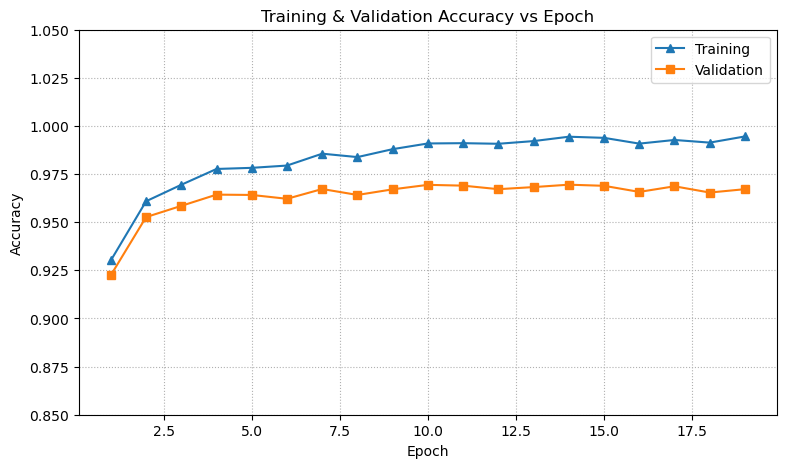

In [ ]:
ax_epoch = np.arange(start=1, stop=len(accuracies_train)+1, step=1)
plt.figure(figsize=(9,5))
plt.plot(ax_epoch, accuracies_train, '^-', label="Training")
plt.plot(ax_epoch, accuracies_val, 's-', label="Validation")
plt.grid(linestyle=':')
plt.ylim([0.85, 1.05])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy vs Epoch")
plt.legend()
plt.show()
plt.close()

If everything went smoothly, all accuracies must have reached a decent value. Also, the expected behavior is $1 > \text{train_acc} > \text{val_acc} > \text{test_acc} > 0$:

In [ ]:
print(f"Accuracies after training:\n Train = {model_accuracy(train_loader):.4f}\n Val   = {model_accuracy(val_loader):.4f}\n Test  = {model_accuracy(test_loader):.4f}")

Accuracies after training:
 Train = 0.9946
 Val   = 0.9672
 Test  = 0.9706


## <u>Homework (optional) </u>

-How sensitive is this model to initialization?

-Try to find better hyperparameters and reduce the total number of training parameters, compromising as little accuracy as you can.

-See if this model correctly classifies digits generated from a GMM like the one of our previous tutorial.